

## Machine Learning using K-Means and DBSCAN algorithm <br>



#### Author: Xunzhe Wen

<br>
### (1) Load the collected data and visulize the data by using scatter plot. 

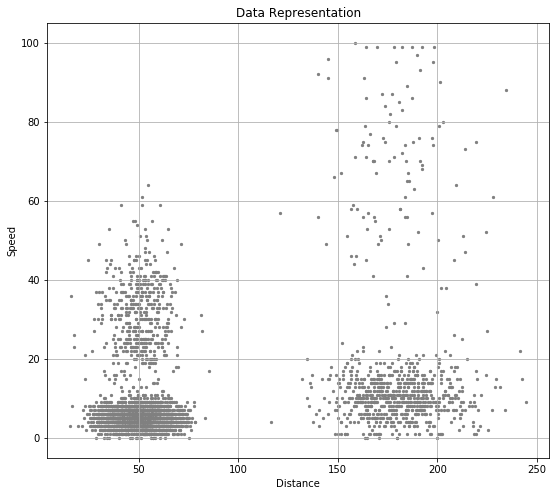

In [56]:
import numpy as np
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

data=np.loadtxt('driverlog.txt')
distance=data[:,1]
speed=data[:,2]
dataSet=np.vstack((distance,speed)).T

plt.figure(figsize=(9,8))
plt.title('Data Representation')
plt.xlabel('Distance')
plt.ylabel('Speed')
plt.scatter(distance,speed,c='grey',s=5)
plt.grid()
plt.show()

<br>
### (2) K-Means clustering (k=5).
K-means algorithm are a commonly-used unsupervised learning algorithm. I am not going into specific details about the algorithm, but an example to implemented this algorithm. Some explanations are also allocated within the following codes.<br>

+ Create and Initilize the Centroids;<br>
+ When the cluster allocation for a certain point is changed:<br>
+ $~~~$In terms of each point:<br>
+ $~~~~~~~~~$ In terms of each centroid:<br>
+ $~~~~~~~~~~~~~~~$ Compute the edulic-distance between the point and centroid;<br>
+ $~~~~~~~~~$ Assign this point to the nearest cluster;<br>
+ $~~~$Compute the mean of the points in the cluster, and the mean will be the updated centroid.<br>

In this part, I chose the hyperparameter $k=5$. 


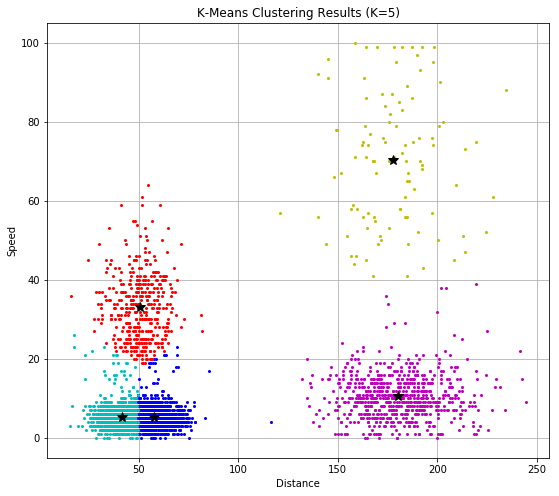

In [57]:
def K_Means(data, k):  
    
    row=data.shape[0]
    col=data.shape[1]
    
    # Initilized the centroid randomly
    init_centroid_index = np.random.choice(row, k, replace=False)
    current_centroid = data[init_centroid_index]
    previous_centroid = np.zeros((k,col))
    cluster_info = np.zeros(row)
    
    # Excute only if the centroid is still changing
    while (previous_centroid != current_centroid).any():
        
        previous_centroid = current_centroid.copy()
        
        # Edulic distance between each data point and centroid 
        eDistance = distance_matrix(data, current_centroid, p=2)
        
        # Find the nearest centroid to cluster
        for i in range(row):
            dist = eDistance[i]
            nearest_centroid = (np.where(dist==np.min(dist)))[0][0]
            cluster_info[i] = nearest_centroid
        
        # Assign the clusters which it would belong to
        for j in range(k):
            p = data[cluster_info == j]
            current_centroid[j]=np.apply_along_axis(np.mean, axis=0, arr=p)
        
    return (current_centroid, cluster_info)

k=5
centroids,clusters = K_Means(dataSet,k)

# Data and clustering results presentation
color1 = ['or', 'ob', 'oy', 'om', 'oc']  
plt.figure(figsize=(9,8))
plt.title('K-Means Clustering Results (K=5)')
plt.xlabel('Distance')
plt.ylabel('Speed')

row=data.shape[0]

for i in range(row):
    colorIndex = int(clusters[i])  
    plt.plot(dataSet[i, 0], dataSet[i, 1], color1[colorIndex], markersize=2)  

color2 = ['*k', '*k', '*k', '*k', '*k']  

for i in range(k):  
    plt.plot(centroids[i, 0], centroids[i, 1], color2[i], markersize = 10)
plt.grid()
plt.show()  


As the intuitively represented different clusters with different colors, where we can see the dataset is divided in to 5 parts, or clusters. The centroid for each cluster is denoted by the Black star, and located at the center of each cluster. <br>
Also, the K-Means algorithm is a distance-based clustering method, thus its performance is highly dependent to the data representation, such as the scale, or normalization of the data set.

<br>
### (3) DBSCAN (Epsilon=5, minPts=5). <br>
DBSCAN is a desity-based clustering method, which can be perfored under a noisy situation. I will assume that we have already fimiliar with the term such as neighbourhood, core points... There are two hyperparameters in this algorithm needs to be tuned. The basic idea of this algorithm can be demonstrated as:<br> 

+ Compute the neighbourhood to identify the core points, board points, and noise with respect to the data point density;<br>
+ According to the each core point, add or extend its neighbourhood to the same cluster, until this cluster area is not changing its size;<br>
+ Manipulate every core points until all points have been visited;<br>
+ Plot each cluster area and noise.<br>

The hyperparameter $\epsilon$ controls the radius of the neighbourhood for each data point; and $minpts$ serves as the density threshold to distinguish the core points.
In this part $\epsilon$ and $minpts$ are both chosen to be 5.

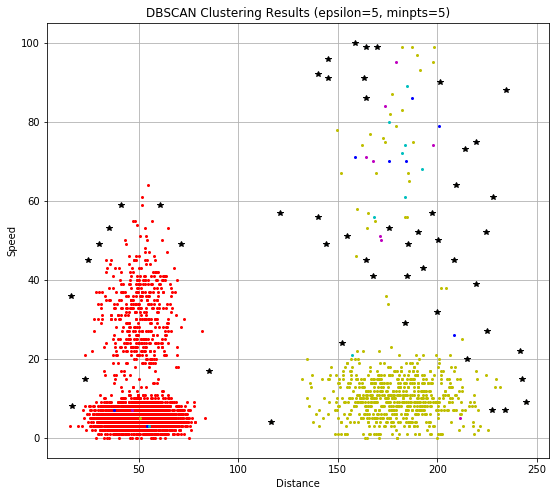

In [58]:
from sklearn.metrics.pairwise import euclidean_distances

#construct the data frame
data=pd.DataFrame(columns=['X','Y'])

data['X']=distance
data['Y']=speed

data=data.reset_index(drop=True)

# Hyperparameters
epsilon = 5
minPts = 5

ptses = []

# euclidean_distance returns a matrix contains distance among all the points 
dist = euclidean_distances(data)

# Indentify core points, board points, and noise
for row in dist:
    
    density = np.sum(row < epsilon)
    pts = 0
    
    if density > minPts:
        pts = 1
    elif density > 1:
        pts = 2
    else:
        pts = 0
        
    ptses.append(pts)

corePoints = data[pd.Series(ptses)!=0]  # De-noise points
noisePoints = data[pd.Series(ptses)==0] # Noise Points

coreDist = euclidean_distances(corePoints) # Distance between non-noise core points

cluster = dict()
m = 0

for row in coreDist: 
    cluster[m] = np.where(row < epsilon)[0]
    m = m + 1

# Merge, or can say, growth of the non-noise points which belongs to the same cluster
for i in range(len(cluster)):
    for j in range(len(cluster)):
        if len( set(cluster[j]) & set(cluster[i]) ) > 0 and i!=j:
            cluster[i] = list(set(cluster[i]) | set(cluster[j]))
            cluster[j] = list()

result = dict()
n = 0
for i in range(len(cluster)):
    if len(cluster[i])>10:
        result[n] = cluster[i]
        n = n + 1

# Data and clustering results presentation
color = ['or', 'ob', 'oy', 'om', 'oc', '*k']   
ind = 0
plt.figure(figsize=(9,8))
plt.title('DBSCAN Clustering Results (epsilon=5, minpts=5)')
plt.xlabel('Distance')
plt.ylabel('Speed')      
for i in range(len(result)):
    for j in result[i]:
        flag = j
        plt.plot(dataSet[flag,0], dataSet[flag,1], color[i], markersize=2)
        ind = ind + 1
        
apos = np.array(noisePoints['X'])
bpos = np.array(noisePoints['Y'])

for i in range(len(apos)):
    plt.plot(apos[i], bpos[i], color[5], markersize=6)
        
plt.grid()
plt.show()  

As the intuitively represented different clusters with different colors, where we can see the dataset is mainly divided in to 2 parts, or clusters, and the noise point is marked as the larger Black star.
Also, the DBSCAN algorithm is a desity-based clustering method, during the implementation, we can see that the noise has been isolated. Compared with K-Means, DBSCAN requires no perior kownledge about the cluster's number. But the hyperparameters is not that easy to be determined in practical cases, and when the data is in highly-dimentional, DBSCAN performance would be worse.